In [1]:
import dlib
import cv2
import os
import json
from PIL import Image, ImageChops, ImageEnhance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras_preprocessing
from keras_preprocessing import image
import shutil


from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train_frame_folder = '/content/drive/MyDrive/DATA/dfdc_train_part_05/dfdc_train_part_5'

real_file_path = "/content/drive/MyDrive/DATA/faceforensic_work/original_sequences/youtube/c23/videos"
real_save_path = "/content/drive/MyDrive/DATA/NewData/real"



train_frame_folder = real_file_path

# meta_path = ""

# for i in os.listdir(train_frame_folder):
#     if i.split(".")[1] == "json":
#         meta_path = train_frame_folder + "/" + i

# with open(os.path.join(train_frame_folder, meta_path), 'r') as file:
#     data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(7)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]

                cv2.imwrite(real_save_path +'/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)

                # if data[vid]['label'] == 'REAL':
                #     cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/real/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)
                # elif data[vid]['label'] == 'FAKE':
                #     cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/fake/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame) 
                #     # print(count+1)
                count+=1

In [ ]:
fake_file_path = "/content/drive/MyDrive/DATA/faceforensic_work/manipulated_sequences/Deepfakes/c23/videos"
fake_save_path = "/content/drive/MyDrive/DATA/NewData/fake"

train_frame_folder = fake_file_path

# meta_path = ""

# for i in os.listdir(train_frame_folder):
#     if i.split(".")[1] == "json":
#         meta_path = train_frame_folder + "/" + i

# with open(os.path.join(train_frame_folder, meta_path), 'r') as file:
#     data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]

                cv2.imwrite(fake_save_path +'/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)

                # if data[vid]['label'] == 'REAL':
                #     cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/real/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame)
                # elif data[vid]['label'] == 'FAKE':
                #     cv2.imwrite('/content/drive/MyDrive/DATA/DeepVideos/test_data/fake/'+vid.split('.')[0]+'_'+str(count)+'.jpg', frame) 
                #     # print(count+1)
                count+=1

In [3]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

In [4]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x)

17235968/17225924 [==============================] - 0s 0us/step


In [5]:
model = tf.keras.models.Model(inputs=base_model.input,outputs=preds)

In [7]:
TRAINING_DIR = "/content/drive/MyDrive/DATA/NewData"
batch_size = 100
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.2)

# VALIDATION_DIR = "/content/drive/MyDrive/DATA/DeepVideos/test_Data"
validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size= batch_size,
  subset = 'training',
  shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size= batch_size,
  subset = 'validation',
  shuffle = True)

Found 16172 images belonging to 2 classes.
Found 4042 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'fake': 0, 'real': 1}

In [9]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [10]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')

from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/content/drive/MyDrive/DATA/faceforensic_work/training.log', separator=',', append=False)


# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10,
                  validation_data = validation_generator,
                  validation_steps = validation_generator.n // validation_generator.batch_size,
                  callbacks=[early_stopping, csv_logger])

model.save("/content/drive/MyDrive/DATA/faceforensic_work/new_model_early.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
161/161 [==============================] - 5516s 34s/step - loss: 0.2331 - accuracy: 0.9482 - val_loss: 0.3036 - val_accuracy: 0.9488
Epoch 2/10
161/161 [==============================] - 361s 2s/step - loss: 0.2059 - accuracy: 0.9493 - val_loss: 0.2070 - val_accuracy: 0.9490
Epoch 3/10
161/161 [==============================] - 357s 2s/step - loss: 0.1918 - accuracy: 0.9492 - val_loss: 0.2344 - val_accuracy: 0.9490
Epoch 4/10
161/161 [==============================] - 355s 2s/step - loss: 0.1798 - accuracy: 0.9490 - val_loss: 0.2033 - val_accuracy: 0.9495
Epoch 5/10
161/161 [==============================] - 354s 2s/step - loss: 0.1727 - accuracy: 0.9496 - val_loss: 0.4573 - val_accuracy: 0.8335
Epoch 6/10
161/161 [==============================] - 352s 2s/step - loss: 0.1646 - accuracy: 0.9496 - val_loss: 0.2899 - val_accuracy: 0.9488


In [12]:
a = model.evaluate(validation_generator, verbose=1)
a

41/41 [==============================] - 40s 973ms/step - loss: 0.2894 - accuracy: 0.9490


[0.2894130051136017, 0.949035108089447]

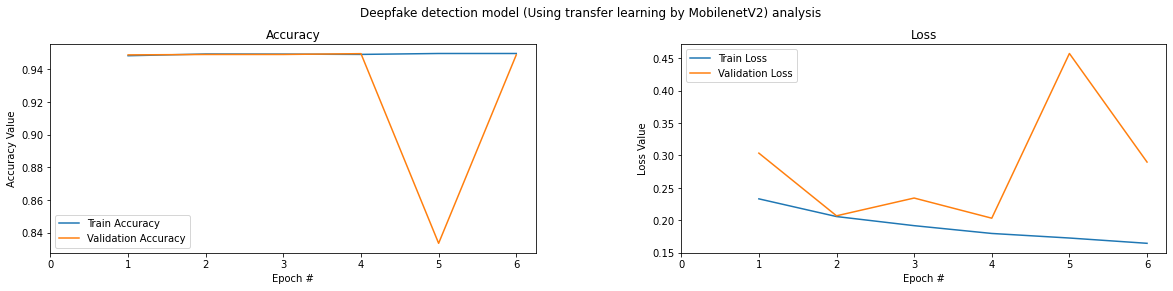

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Deepfake detection model (Using transfer learning by MobilenetV2) analysis', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,len(history.epoch)+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, len(history.epoch)+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, len(history.epoch)+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [ ]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()


imag_pred = []
y = []

for fn in os.listdir("/content/drive/MyDrive/DATA/NewData"):
  # predicting images
  for i in os.listdir("/content/drive/MyDrive/DATA/NewData/" + str(fn)):
    if fn == "fake":
      y.append(0)
    elif fn == "real":
      y.append(1)
    path = "/content/drive/MyDrive/DATA/NewData/" + str(fn) + "/" + str(i)
    img = load_img(path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    
    imag_pred.append(round(model.predict(images)[0][0]))

    
print_confusion_matrix(y, imag_pred)